<a href="https://colab.research.google.com/github/Khoawawa/ArtDetective/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

100%|██████████| 9.76G/9.76G [02:22<00:00, 73.6MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4


In [3]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import seaborn as sns
import time
import random
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from skimage.feature import hog
from skimage.feature import local_binary_pattern

In [4]:
def set_seed(seed=42):
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's random module

set_seed()

In [5]:

TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

In [6]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']

In [7]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [8]:
IMG_SIZE = (150,150)

In [9]:
def extract_lbp_features(img_path, radius=3, points=24,method="uniform"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh xám
    if img is None:
        print(f"Error loading image: {img_path}")
        return np.zeros(points + 2)  # Tránh lỗi khi ảnh không load được

    img = cv2.resize(img, (64, 64))  # Resize ảnh về kích thước cố định
    lbp = local_binary_pattern(img, points, radius, method)  # Áp dụng LBP

    # Tính histogram của các giá trị LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Chuẩn hóa histogram tránh lỗi chia cho 0
    return hist


In [10]:
X = np.array([extract_lbp_features(os.path.join(path,img_path)) for img_path in train_df['id']])
y = np.array(train_df['label'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
}

In [13]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [14]:
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:16:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=3)

In [18]:
best_model = grid_search.best_estimator_

In [19]:
y_pred = best_model.predict(X_test)

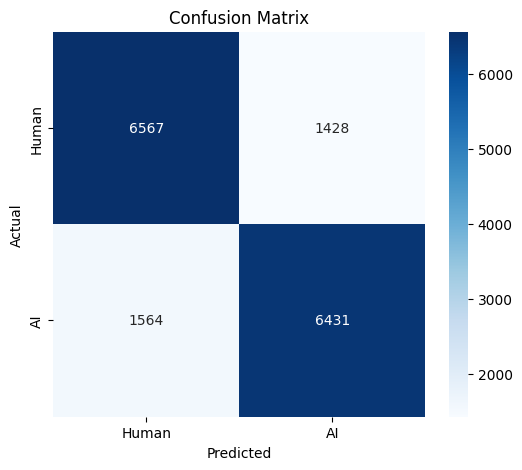

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
import joblib

# save
save_path = "/content/drive/My Drive/xgboost_V1.pkl"
joblib.dump(best_model,save_path)

['/content/drive/My Drive/xgboost_V1.pkl']